In [5]:
import os
from src.utilities.polar_traversal import (scale_mesh, flip_mesh)
from torchvision.transforms import ToPILImage
from src.augment.geoaug import GeoAugment

from src.config import get_parser

In [1]:
import os
import torch 
import torch.nn.functional as F 

from pytorch3d.structures import Pointclouds
import pytorch3d.transforms as T3
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    RasterizationSettings,
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex,
)
from pytorch3d.renderer.blending import BlendParams
from src.utilities.util import make_faces
from src.utilities.util import  grid_to_list

class MeshPointsRenderer(torch.nn.Module):
    def __init__(self, opt):    
        super(MeshPointsRenderer, self).__init__()
        self.opt = opt
        self.max_brightness = opt.raster_max_brightness        
        size = opt.fast_outline_size
        self.register_buffer('faces',  torch.tensor(make_faces(size, size))[None])
        self.renderer = None
    
    def setup(self, device):                    
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint_azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = RasterizationSettings(
            image_size= self.opt.fast_image_size, 
            blur_radius=self.opt.raster_blur_radius, 
            faces_per_pixel=self.opt.raster_faces_per_pixel,
        )
        rasterizer= MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )        
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        shader = SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights,
            blend_params=BlendParams(
              self.opt.blend_params_sigma,
              self.opt.blend_params_gamma,
              self.opt.blend_params_background_color,
            ),
        )        
        self.renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader,
        )
    
    def __call__(self, vertices, faces, device):                
        colors = torch.ones_like(verts)
        if  self.renderer is None:
            self.setup(device)        
        textures = TexturesVertex(verts_features=colors)

        mesh = Meshes(verts=verts, faces=faces, textures=textures)
        r_images = self.renderer(mesh)        
        r_images = r_images.permute(0, 3, 1, 2).contiguous()
        r_images = r_images[:, :3, :, :].mean(dim=1, keepdim=True)        
        return r_images
    
config = get_parser().parse_args(args=[])   

config.fast_image_size = 512
config.raster_faces_per_pixel = 4

R = MeshPointsRenderer(config)
device = torch.device('cuda')

NameError: name 'get_parser' is not defined

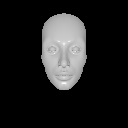

In [22]:
ToPILImage()(renders[0])

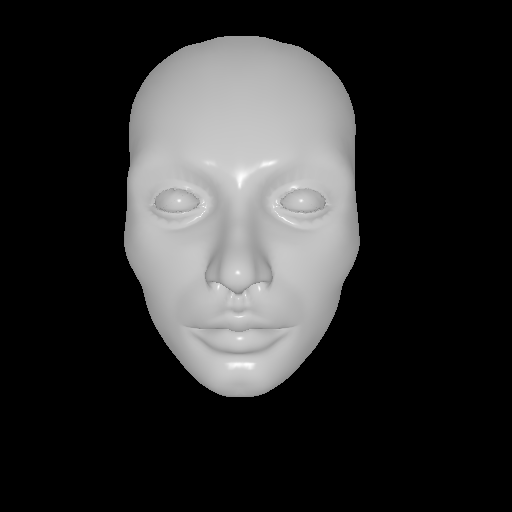

In [12]:
mesh  = flip_mesh(scale_mesh('./data/female_face.stl', offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()
faces = torch.tensor(mesh.faces, device=device)[None]

verts = GeoAugment(verts, config.geoaug_policy)[None]
renders =  R(verts, faces, device)
renders.shape
img = ToPILImage()(renders[0])
img

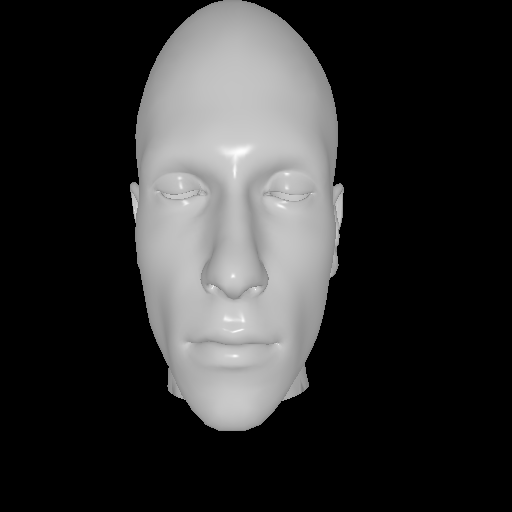

In [18]:
file = '/home/bobi/Desktop/db/data/stl_head/abe_white_inpatient.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()
faces = torch.tensor(mesh.faces, device=device)[None]

verts = GeoAugment(verts, config.geoaug_policy)[None]
renders =  R(verts, faces, device)
renders.shape
img = ToPILImage()(renders[0])
img

In [16]:
img.save("./converted.png", format="png")

In [25]:
stl_dir = '/home/bobi/Desktop/db/data/stl_head/'
stls = [s for s in os.listdir(stl_dir) if s.endswith('.stl')]  
stls.sort()
stls

['abe_white_inpatient.stl',
 'abigaile_ortiz_tomb_raider.stl',
 'ada_wong_resident_evil.stl',
 'administrator_evil_within.stl',
 'aidan_overkill_walking_dead.stl',
 'aloy_horizon_zero_dawn.stl',
 'amelia_croft_tomb_raider.stl',
 'anakin_battlefront_2.stl',
 'angela_civilian_detroit.stl',
 'annie_dead_rising.stl',
 'aphrodite_ascendant_one.stl',
 'ares_ascendant_one.stl',
 'artemis_ascendant_one.stl',
 'ashley_until_dawn_3ds.stl',
 'badgirl_no_more_heroes.stl',
 'badman_no_more_heroes.stl',
 'becky_hidden_agenda.stl',
 'black_lightning_injustice_2.stl',
 'bridger_overkill_walking_dead.stl',
 'cameron_burke_far_cry.stl',
 'carl_detroit.stl',
 'cassie_drake_uncharted.stl',
 'catherine_hidden_agenda.stl',
 'chloe_detroit.stl',
 'claire_resident_evil.stl',
 'connor_detroit.stl',
 'daniel_detroit.stl',
 'dante_dmc.stl',
 'dengar_battlefront_2.stl',
 'dooku_battlefront_2.stl',
 'earl_whitehorse_far_cry.stl',
 'eden_girl_detroit.stl',
 'elena_fisher_uncharted.stl',
 'elisa_two_souls.stl',
 'el

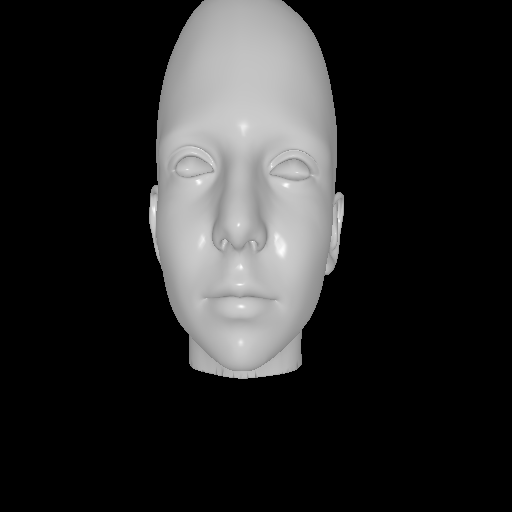

In [35]:
rndr_root = './data/renders/'
for i, stl_file in enumerate(stls):
    mesh  = flip_mesh(scale_mesh(os.path.join(stl_dir, stl_file), offset=-0.20))
    orig_verts = torch.tensor(mesh.vertices, device=device).float()
    faces = torch.tensor(mesh.faces, device=device)[None]
    stl_name = stl_file.replace('.stl', '')
    rndr_dir = os.path.join(rndr_root, stl_name)
    if not os.path.exists(rndr_dir):
        os.makedirs(rndr_dir)
    for i in range(100):        
        verts = GeoAugment(orig_verts.clone(), config.geoaug_policy)[None]
        renders =  R(verts, faces, device)
        renders.shape
        img = ToPILImage()(renders[0])
        img.save(os.path.join(rndr_dir, stl_name+ '_' + f"{i}.png".zfill(7)), format="png")
    
img    

In [31]:
# pyright: reportMissingImports=false
import os
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms import (
    Compose,    
    Normalize,
    Resize,
    RandomHorizontalFlip,
    ToTensor,    
)
from torchvision.datasets import ImageFolder
from src.augment.geoaug import GeoAugment

def pyramid_transform(img_size, mean=0, std=1):
    transform = {        
        'image': Compose([
            Resize([img_size, img_size]),
            RandomHorizontalFlip(),            
            ToTensor(),
            Normalize(mean=(mean), std=(std)),

        ]),        
    }
    def final_transform(img):        
        return {
            'image': transform['image'](img),            
        }
    return final_transform

class RenderDataset(torch.utils.data.Dataset):
    
    def __init__(self, config):
        
        self.num_workers = config.num_workers
        self.pin_memory = config.pin_memory        
        self.outline_size =  config.fast_outline_size
        self.geoaug_policy = config.geoaug_policy

        self.image_root = config.fast_render_root        
        self.image_size = config.fast_image_size        
        self.image_mean = config.fast_image_mean
        self.image_std = config.fast_image_std
        
        blueprint = np.load(os.path.join(config.data_dir, config.blueprint))
        points = torch.tensor(blueprint['points'])                
                       
        self.points = self.scale(points, self.outline_size)                
        
        self.transform = pyramid_transform(self.image_size, 
            self.image_mean, self.image_std)
        self.img_ds = ImageFolder(self.image_root)
        
    def scale(self, t, size):
        return F.interpolate(t, size=size, mode='bicubic', align_corners=True)
        
    def __len__(self):
        return len(self.img_ds)
    
    def __getitem__(self, idx):              
        points = self.points[idx % self.points.size(0)]
        idx_img = idx % len(self.img_ds)
        image, label = self.img_ds[idx_img]        
        res = self.transform(image)
        res['label'] = label
        res['outline'] = GeoAugment(points, policy=self.geoaug_policy)         
        return res
    


'021.png'

In [6]:
from src.data.render_dataset import RenderDataset

config = get_parser().parse_args(args=[])
ds = RenderDataset(config)
ds

In [10]:
ds[0]['image'].shape

torch.Size([3, 128, 128])

In [8]:
from src.data.fast_datamodule import FastDataModule

dm = FastDataModule(config, RenderDataset)
dm

In [9]:
next(iter(dm.train_dataloader()))

{'image': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
